In [ ]:
# Plot Redshift versus near-infrared magnitude, with marker size dependant on luminosity.
# Can alter final section to produce a plot for different redshifts.

In [ ]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
from astropy.cosmology import Planck15,z_at_value
import astropy.units as u
import csv

In [ ]:
# This section was taken from code written by G. Drouart, CIRA. It allows for importation of PEGASE.2 cosmology models.

def read_peg2_file(file):      
    """                                                                                                             
    A python procedure to read the content of PEGASE.2 files                                                        
    input: filename                                                                                                 
    return a dictionnary with all the stuff                                                                         
    """                                                                                                             
                                                                                                   
    import re
    f=open(file,'r')                                                                                                
    i=''                                                                                                            
    # read the header                                                                                               
    header=[]                                                                                                       
    while i[:3]!='***':                                                                                             
        i=f.readline().strip()                                                                                      
        header.append(i)                                                                                            
                        
    # figure out the dimensions                                                                                     
    ntime,nwav,nlines=np.array(re.findall(r'\d+\.*\d*',f.readline())).astype(np.int)                                
                                                                                                                    
    # create the tables                                                                                             
    wav_cont=np.empty(nwav)                                                                                         
    wav_lines=np.empty(nlines)                                                                                      
    flux_cont=np.empty([ntime,nwav])                                                                                
    flux_lines=np.empty([ntime,nlines])                                                                             
    row1=np.empty([ntime,10])                                                                                       
    row2=np.empty([ntime,9])                                                                                        
                                                                                                                    
    # regex magic to find the float from the string line                                                            
    regex_str=r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?'                                                           
    # lambda continuum                                                                                              
    n_filelines_wav_cont=nwav//5                                                                                    
    for i in range(n_filelines_wav_cont):                                                                                                                                                
        wav_cont[5*i:5*i+5]=np.array(re.findall(regex_str,f.readline())).astype(np.float)                           
    if nwav%5>0:                                                                                                    
        wav_cont[5*n_filelines_wav_cont:]=np.array(re.findall(regex_str,f.readline())).astype(np.float)             
                                                                                                                    
    # lambda lines                                                                                                  
    n_filelines_wav_lines=nlines//5                                                                                 
    for i in range(n_filelines_wav_lines):                                                                          
        wav_lines[5*i:5*i+5]=np.array(re.findall(regex_str,f.readline())).astype(np.float)                          
    if nwav%5>0:                                                                                                    
        wav_lines[5*n_filelines_wav_lines:]=np.array(re.findall(regex_str,f.readline())).astype(np.float)           
                                                                                                                    
    # start the loop                                                                                                
    for t in range(ntime):                                                                                          
        row1[t,:]=np.array(re.findall(regex_str,f.readline())).astype(np.float)                                     
        row2[t,:]=np.array(re.findall(regex_str,f.readline())).astype(np.float)                                     
                                                                                                                    
        # lambda continuum                                                                                          
        for i in range(n_filelines_wav_cont):                                                                       
            flux_cont[t,5*i:5*i+5]=np.array(re.findall(regex_str,f.readline())).astype(np.float)                    
        if nwav%5>0:                                                                                                
            flux_cont[t,5*n_filelines_wav_cont:]=np.array(re.findall(regex_str,f.readline())).astype(np.float)      
                                                                                                                    
        # lambda lines                                                                                              
        for i in range(n_filelines_wav_lines):                                                                      
            flux_lines[t,5*i:5*i+5]=np.array(re.findall(regex_str,f.readline())).astype(np.float)    
        if nwav%5>0:                                                                                                
            flux_lines[t,5*n_filelines_wav_lines:]=np.array(re.findall(regex_str,f.readline())).astype(np.float)    
                                                                                                                    
    f.close()                                                                                                       
                                                                                                                    
    # transfer everthing into a dictionnary                                                                         
    peg2_file={'header':header,                                                                                     
               'wav_cont':wav_cont,                                                                                 
               'wav_lines':wav_lines,                                                                               
               'flux_cont':flux_cont,                                                                               
               'flux_lines':flux_lines,                                                                             
               'time':row1[:,0],                                                                                    
               'mass_galaxy':row1[:,1],                                                                             
               'mass_stars':row1[:,2],                                                                              
               'mass_wd':row1[:,3],                                                                                 
               'mass_nsbh':row1[:,4],                                                                               
               'mass_subs':row1[:,5],                                                                               
               'mass_ism':row1[:,6],                                                                                
               'z_sim':row1[:,7],                                                                                   
               'mean_z_mass':row1[:,8],                                                                             
               'mean_z_Lbol':row1[:,9],                                                                             
               'Lbol':row1[:,0],                                                                                    
               'optV_depth':row2[:,1],                                                                              
               'dust_ratio_Lbol':row2[:,2],                                                                         
               'SFR':row2[:,3],                                                                                     
               'Lya_cont_phot':row2[:,4],                                                                           
               'SNII_rate':row2[:,5],                                                                               
               'SNI_rate':row2[:,6],                                                                                
               'mean_age_mass':row2[:,7],                                                                           
               'mean_age_Lbol':row2[:,8]}                                                                           
    return peg2_file                                                                                                

def integrate_filter(sed_nu, sed_flux, filter_nu, filter_trans):                                                
    """                                                                                                         
    Function integrating SED flux over a specific filter                                                        
                                                                                                                
    :param sed_nu: array of frequencies of the SED                                                              
    :param sed_flux: array of flux of the SED (at each frequency)                                               
    :param filter_nu: array of frequencies of the filter                                                        
    :param filter_trans: array of transmission of the filter at each frequency                                  
    :return: integrated flux                                                                                    
    """                                                                                                         
    filter_trans_interp = np.interp(sed_nu, filter_nu, filter_trans, right=0.0, left=0.0)                       
                                                                                                                
    if min(filter_nu) < min(sed_nu) or max(filter_nu) > max(sed_nu):                                            
        print("filter outside range!")                                                                           
        return 0.0                                                                                              
    else:                                                                                                       
        # find max filter                                                                                       
        i1 = np.where(filter_trans_interp >= max(filter_trans_interp)/5.)[0][0]                                 
        i2 = np.where(filter_trans_interp >= max(filter_trans_interp)/5.)[0][-1]                                
                                                                                                                
        ic = np.floor((i1 + i2) / 2.)                                                                           
        scale_w = np.abs(sed_flux[int(ic)])                                                                     
                                                                                                                
        k1 = 0                                                                                                  
        if np.isfinite(scale_w) and scale_w > 0:                                                                
            k1 = scale_w * np.trapz((sed_flux * sed_nu / scale_w) * filter_trans_interp, x=sed_nu)              
        k2 = np.trapz(sed_nu * filter_trans_interp, x=sed_nu)                                                   
        return k1 / k2                                                                                          

def read_single_filter(name):                                                                                   
    """ Read a single filter """                                                                                
    with open(name, 'rb'):                                                                                      
        try:                                                                                                    
            wav, trans = np.genfromtxt(name, unpack=True)                                                       
            return wav, trans                                                                                   
        except IOError:                                                                                         
            print("{} filter file does not exist".format(name))

In [ ]:
# Import peg2 and filter files.

nu_Ks,t_Ks=read_single_filter('HAWKI_Ks.dat')
E_temp=read_peg2_file('E.spec')

In [ ]:
# Adapted from code provided by G. Drouart.
# Produces models of galaxy mass functions generated by the PEGASE.2 galaxy mass simulation (Rocca-Volmerange et al., 2004).
# Three different for 3 different galactic formation timelines (z=10, 8, 16)

# z form = 10
with np.errstate(divide='ignore'):
    z_form=10
    time_scale=E_temp['time'][:-7]*u.Myr+Planck15.age(z_form)
    zscale=np.array([z_at_value(Planck15.age,i) for i in time_scale])
    mass=np.array([1e10,1e11,1e12])
    Ks_mag=np.zeros([mass.size,E_temp['time'][:-7].size,zscale.size])
    dist=Planck15.luminosity_distance(zscale)
    light=3e18 # c as Ang/s
    for m,elemm in enumerate(mass):
        for t,elemt in enumerate(E_temp['time'][:-7]):
            for z,elemz in enumerate(zscale):
                y_tmp=E_temp['flux_cont'][t]*elemm/(1+elemz)/\
                (4.*np.pi*dist[z].to(u.cm).value*dist[z].to(u.cm).value)
                av=integrate_filter(E_temp['wav_cont']*(1+elemz),y_tmp,nu_Ks,t_Ks)
                Ks_mag[m,t,z]=-2.5*np.log10(2.2e4*2.2e4*av/light)-48.6

# z form = 8
with np.errstate(divide='ignore'):
    z_form8=8
    time_scale_z8=E_temp['time'][:-7]*u.Myr+Planck15.age(z_form8)
    zscale_z8=np.array([z_at_value(Planck15.age,i) for i in time_scale_z8])
    mass8=np.array([1e10,1e11,1e12])
    Ks_mag_extend1=np.zeros([mass8.size,E_temp['time'][:-7].size,zscale_z8.size])
    dist_z8=Planck15.luminosity_distance(zscale_z8)
    light=3e18 # c as Ang/s
    for m,elemm in enumerate(mass8):
        for t,elemt in enumerate(E_temp['time'][:-7]):
            for z,elemz in enumerate(zscale_z8):
                y_tmp=E_temp['flux_cont'][t]*elemm/(1+elemz)/\
                (4.*np.pi*dist_z8[z].to(u.cm).value*dist_z8[z].to(u.cm).value)
                av=integrate_filter(E_temp['wav_cont']*(1+elemz),y_tmp,nu_Ks,t_Ks)
                Ks_mag_extend1[m,t,z]=-2.5*np.log10(2.2e4*2.2e4*av/light)-48.6 

# z form = 16
with np.errstate(divide='ignore'):
    z_form16=16
    time_scale_z16=E_temp['time'][:-7]*u.Myr+Planck15.age(z_form16)
    zscale_z16=np.array([z_at_value(Planck15.age,i) for i in time_scale_z16])
    mass16=np.array([1e10,1e11,1e12])
    Ks_mag_extend2=np.zeros([mass16.size,E_temp['time'][:-7].size,zscale_z16.size])
    dist_z16=Planck15.luminosity_distance(zscale_z16)
    light=3e18 # c as Ang/s
    for m,elemm in enumerate(mass16):
        for t,elemt in enumerate(E_temp['time'][:-7]):
            for z,elemz in enumerate(zscale_z16):
                y_tmp=E_temp['flux_cont'][t]*elemm/(1+elemz)/\
                (4.*np.pi*dist_z16[z].to(u.cm).value*dist_z16[z].to(u.cm).value)
                av=integrate_filter(E_temp['wav_cont']*(1+elemz),y_tmp,nu_Ks,t_Ks)
                Ks_mag_extend2[m,t,z]=-2.5*np.log10(2.2e4*2.2e4*av/light)-48.6 

In [ ]:
# initialise files for import/plotting (Only Radio Galaxies, all else removed)
filename1 = 'drouart 3c.csv' 
filename2 = 'drouart 6c.csv'
filename3 = 'drouart hzrgs.csv'
filename4 = 'Saxena data.csv'
filename5 = 'drouart 2020.csv'

# read the catalogues
hzrg_3c=np.genfromtxt('drouart 3c.csv',delimiter=",",usecols=(1,2,6,8),names=True,dtype=None)
hzrg_6c=np.genfromtxt('drouart 6c.csv',delimiter=",",usecols=(1,2,4,6,8),names=True,dtype=None)
hzrg_sample=np.genfromtxt('drouart hzrgs.csv',delimiter=",",usecols=(1,2,6,8),names=True,dtype=None)
hzrg_saxena=np.genfromtxt('Saxena data.csv',delimiter=",",usecols=(1,2,6,4,8),names=True,dtype=None)
hzrg_drouart=np.genfromtxt('drouart 2020.csv',delimiter=",",usecols=(1,2,4,6,8),names=True,dtype=None)

In [ ]:
# Methods for calculation/conversion of units, etc
# Note: dl = luminosity distance (in metres), S_nu = flux density at freq nu (in mJy), alpha = spectral index, z = redshift

def L1400(redshift, flux, alpha):
    for value in redshift:
        try:
            flux=flux * 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert flux from mJy to W/m^2/Hz
            redshift = redshift * u.dimensionless_unscaled
            dL = Planck15.luminosity_distance(redshift).to(u.m) #convert Mpc to metres
            alpha=alpha * u.dimensionless_unscaled
            lum_1400 = 4.*np.pi*dL*dL*flux*((1+redshift)**-(1+alpha))
            return lum_1400
        except:
            continue
            
def S500(S1400,alpha):
    for value in S1400:
        try:
            S1400=S1400 * 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert S_1400 flux from mJy to W/m^2/Hz
            alpha=alpha * u.dimensionless_unscaled
            S_500 = S1400*(500/1400)**alpha # extrapolate S500 from S1400 and alpha values
            return S_500
        except:
            continue

def L500(S500,redshift,alpha): # assuming S500 is correctly in SI after processing by 'S500' method
    for value in S500:
        try:
            redshift = redshift * u.dimensionless_unscaled
            alpha = alpha * u.dimensionless_unscaled 
            dL = Planck15.luminosity_distance(redshift).to(u.m) #convert Mpc to metres
            lum_500 = 4.*np.pi*dL*dL*S500*((1+redshift)**-(1+alpha))
            return lum_500
        except:
            continue

In [ ]:
# calculate Luminosity at 500 MHz for each dataset

# can this code by optimised further??

# L500 for 3C objects
z_3c = hzrg_3c['z']
s1400_3c = hzrg_3c['S1400']
alpha_3c = hzrg_3c['alpha']
s500_3c = S500(s1400_3c,alpha_3c)
L500_3c = L500(s500_3c,z_3c,alpha_3c)

# L500 for 6C objects
z_6c = hzrg_6c['z']
s1400_6c = hzrg_6c['S1400']
alpha_6c = hzrg_6c['alpha']
s500_6c = S500(s1400_6c,alpha_6c)
L500_6c = L500(s500_6c,z_6c,alpha_6c)

# L500 for 'hzrg' objects
z_hzrg = hzrg_sample['z']
s1400_hzrg = hzrg_sample['S1400']
alpha_hzrg = hzrg_sample['alpha']
s500_hzrg = S500(s1400_hzrg,alpha_hzrg)
L500_hzrg = L500(s500_hzrg,z_hzrg,alpha_hzrg)

# L500 for Saxena objects
z_sax = hzrg_saxena['z']
s1400_sax = hzrg_saxena['S1400']
alpha_sax = hzrg_saxena['alpha']
s500_sax = S500(s1400_sax,alpha_sax)
L500_sax = L500(s500_sax,z_sax,alpha_sax)

# L500 for Drouart objects
z_drouart = hzrg_drouart['z']
s1400_drouart = hzrg_drouart['S1400']
alpha_drouart = hzrg_drouart['alpha']
s500_drouart = S500(s1400_drouart,alpha_drouart)
L500_drouart = L500(s500_drouart,z_drouart,alpha_drouart)

In [ ]:
# calculate marker sizes based on L500, using set luminosity threshold.

Lum_threshold = 1e27 * u.W / u.Hz #units

#Lmarker1 = ['x' if (Lum_threshold - value) > 0 else '^' for value in Lum_value]
Lmarker1 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L500_3c]
Lmarker2 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L500_6c]
Lmarker3 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L500_hzrg]
Lmarker4 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L500_sax]
Lmarker5 = [60 if (value - Lum_threshold) >= 0 else 10 for value in L500_drouart]

In [ ]:
# new source:  MG 1131+0456, K=17.8(Vega), so 17.8(+1.85) in AB
# z=1.849 (unpublished)
# S1400 = 527 mJy (0.527 Jy), S178 = 2300 mJy (2.3 Jy)
# Ref: http://ned.ipac.caltech.edu/byname?objname=MG%201131%2B0456&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

MG1131_K=17.8+1.85
MG1131_z=1.849 * u.dimensionless_unscaled
MG1131_S1400=527 * 1e-29 *(u.W / (u.m*u.m) / u.Hz) #convert flux from mJy to W/m^2/Hz
MG1131_alpha=-0.75 * u.dimensionless_unscaled # i think???

#calculate L500 MHz

dL_MG1131 = Planck15.luminosity_distance(MG1131_z).to(u.m) #convert Mpc to metres
MG1131_S500 = MG1131_S1400*(500/1400)**MG1131_alpha
MG1131_L500 = 4.*np.pi*dL_MG1131*dL_MG1131*MG1131_S500*((1+MG1131_z)**-(1+MG1131_alpha))

Lmarker_MG1131=[60 if (MG1131_L500 - Lum_threshold) > 0 else 10]

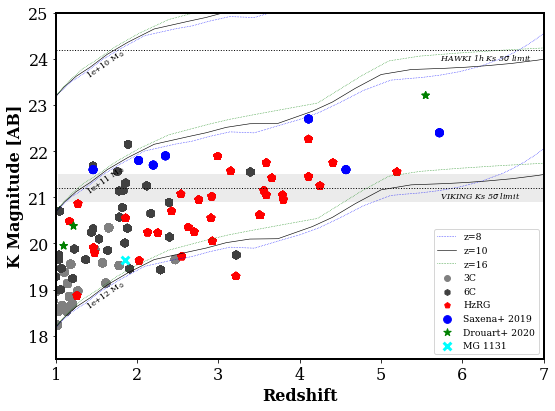

In [ ]:
# Plot the data
# Can be adjusted to produce a plot at z > 1 

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelweight'] = 600
plt.rcParams['axes.titlesize'] = 'x-large'

# plot each data set
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

# on/off for full/ z> 1
#plt.xscale('log') 

# format x-axis 
#plt.xlim([0.025, 8.5]) # full limit
plt.xlim([1.0, 7.0]) # z>1 limit
#plt.xticks([0.1, 1.0, 6.0])
plt.minorticks_off()
plt.xlabel('Redshift')

#format y-axis
#plt.ylim(12.1, 25.0) # full limit
plt.ylim(17.5,25.0) # z>1 limit
plt.ylabel('K Magnitude [AB]')

# remove scientific notation from x-axis
from matplotlib.ticker import ScalarFormatter
sf = ScalarFormatter()
sf.set_scientific(False)
ax.xaxis.set_major_formatter(sf)

# limits taken from survey website/literature
viking_5siglim=21.2
hawki_5siglim=24.2

ax.axhline(y=viking_5siglim,ls=':',linewidth=1,c='k')
ax.text(5.7,21.15,' VIKING Ks 5$\sigma$ limit',va='top',ha='left',fontsize=8, style='italic')
#ax.text(ax.get_xlim()[0],viking_5siglim-0.4,' VIKING Ks 5$\sigma$ limit',va='top',ha='left',fontsize=8, style='italic') #full
ax.axhspan(20.9, 21.5, xmin=0.005, xmax=8.0, facecolor = '0.85', alpha=0.5, zorder=-1)

ax.axhline(y=hawki_5siglim,ls=':',linewidth=1,c='k')
ax.text(5.7,24.15,' HAWKI 1h Ks 5$\sigma$ limit',va='top',ha='left',fontsize=8, style='italic')
#ax.text(ax.get_xlim()[0],hawki_5siglim-0.1,' HAWKI 1h Ks 5$\sigma$ limit',va='top',ha='left',fontsize=8, style='italic') #full

# can these plot commands be optimised?

#plot 3C data:
label1 = False
for value in Lmarker1:
    if not label1:
        ax.scatter(hzrg_3c['z'],hzrg_3c['K']+1.85, s=[Lmarker1], c='0.5', facecolors='none', label='3C')
        label1 = True
    else:
        ax.scatter(hzrg_3c['z'],hzrg_3c['K']+1.85, s=[Lmarker1], c='0.5', facecolors='none')

# plot 6C data
label2 = False
for value in Lmarker2:
    if not label2:
        ax.scatter(hzrg_6c['z'],hzrg_6c['K']+1.85, marker='h', c='0.25', s=[Lmarker2], label='6C')
        label2 = True
    else:
        ax.scatter(hzrg_6c['z'],hzrg_6c['K']+1.85, marker='h', c='0.25', s=[Lmarker2])

# plot hzrg sample
label3=False     
for value in Lmarker3:
    if not label3:
        ax.scatter(hzrg_sample['z'],hzrg_sample['K']+1.85, marker='p', color='red', s=[Lmarker3],label='HzRG')
        label3=True
    else:
        ax.scatter(hzrg_sample['z'],hzrg_sample['K']+1.85, marker='p', color='red', s=[Lmarker3])

#plot Saxena sources
label4=False
for value in Lmarker4:
    if not label4:
        ax.scatter(hzrg_saxena['z'],hzrg_saxena['K'], marker='o', color='blue', s=[Lmarker4],label='Saxena+ 2019')
        label4=True
    else:
        ax.scatter(hzrg_saxena['z'],hzrg_saxena['K'], marker='o', color='blue', s=[Lmarker4])

# plot Druart sources
label5=False
for value in Lmarker5:
    if not label5:
        ax.scatter(hzrg_drouart['z'],hzrg_drouart['K'], marker='*', color='green', s=[Lmarker5],label='Drouart+ 2020')
        label5=True
    else:
        ax.scatter(hzrg_drouart['z'],hzrg_drouart['K'], marker='*', color='green', s=[Lmarker5])

# Plotting MG 1131+0456
ax.scatter(MG1131_z,MG1131_K, s=Lmarker_MG1131, marker='x', color='cyan', label='MG 1131')
    
# z-form at z=8
label_z8=False
for i,elem in enumerate(mass8):
    if not label_z8:
        tmp=np.diag(Ks_mag_extend1[i])
        ax.plot(zscale_z8,tmp,c='b',zorder=1,lw=0.6,ls=':',label='z=8')
        label_z8=True
    else:
        tmp=np.diag(Ks_mag_extend1[i])
        ax.plot(zscale_z8,tmp,c='b',zorder=1,lw=0.6,ls=':')
        
# calculation with pegase for the K-band at z(form)=10
label_z10=False
for i,elem in enumerate(mass):
    if not label_z10:
        tmp=np.diag(Ks_mag[i])
        ax.plot(zscale,tmp,c='k',zorder=1,lw=0.6, label='z=10')
        ax.annotate("{:1g} M$_\odot$".format(elem),(zscale[49],tmp[50]),ha='right',rotation=35,fontsize=8)
        label_z10=True
    else:
        tmp=np.diag(Ks_mag[i])
        ax.plot(zscale,tmp,c='k',zorder=1,lw=0.6)
        ax.annotate("{:1g} M$_\odot$".format(elem),(zscale[49],tmp[50]),ha='right',rotation=35,fontsize=8)

# (zscale[49],tmp[50]) for z > 1
# (zscale[-2],tmp[-2]) for full log
        
# z-form at z=16
label_z16=False
for i,elem in enumerate(mass16):
    if not label_z16:
        tmp=np.diag(Ks_mag_extend2[i])
        ax.plot(zscale_z16,tmp,c='g',zorder=1,lw=0.6,ls=':',label='z=16')
        label_z16=True
    else:
        tmp=np.diag(Ks_mag_extend2[i])
        ax.plot(zscale_z16,tmp,c='g',zorder=1,lw=0.6,ls=':')

# format legend
plt.legend(loc = 'lower right', fontsize= 'xx-small')
        
#show plot and save as pdf
fig1 = plt.gcf()
fig1.tight_layout()
fig1.savefig('K-z_L500_zforms_zgt1.pdf', dpi=500)
#fig1.savefig('K-z_L500_zforms_full_log.pdf', dpi=500)

plt.show()